In [2]:
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline
from dotenv import load_dotenv
np.random.seed(42)

In [24]:
load_dotenv()
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_API_SECRET_KEY")
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

ticker = ["SPY", "AGG"]
timeframe = "1D"
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

daily_return = df.pct_change()
AGG_mean = daily_return.mean()["AGG"]["close"]
SPY_mean = daily_return.mean()["SPY"]["close"]

SPY_daily_std = daily_return.std()["AGG"]["close"]
AGG_daily_std = daily_return.std()["SPY"]["close"]

spylast = df["SPY"]["close"][-1]
agglast = df["AGG"]["close"][-1]

In [8]:
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
portfolio = pd.DataFrame()
for n in range(number_simulations):
    spy_simulated_prices = [spylast]
    agg_simulated_prices = [agglast]
    for i in range(number_records):
        spy_simulated = spy_simulated_prices[-1] * (1 + np.random.normal(SPY_mean, SPY_daily_std))
        agg_simulated = agg_simulated_prices[-1] * (1 + np.random.normal(AGG_mean, AGG_daily_std))
        spy_simulated_prices.append(spy_simulated)
        agg_simulated_prices.append(agg_simulated)
    portfolio["SPY"] = pd.Series(spy_simulated_prices)
    portfolio["AGG"] = pd.Series(agg_simulated_prices)
    daily_return_sim = portfolio.pct_change()
    weights = [0.60, 0.40]
    portfolio_daily_returns = daily_return_sim.dot(weights)
    monte_carlo[f"Simulation {n+1}"] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

In [9]:
title = f"{n+1} Simulation of AGG and SPY stock price trajectory over the next 30 years"
monte_carlo.plot(legend =None, title=title)

In [12]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cum = monte_carlo.iloc[20]
#ending_cum = monte_carlo.iloc[20][-1]
ending_cum

Simulation 1      0.993337
Simulation 2      1.012972
Simulation 3      0.999116
Simulation 4      1.034899
Simulation 5      1.002287
                    ...   
Simulation 496    0.997367
Simulation 497    1.017971
Simulation 498    1.033811
Simulation 499    1.000069
Simulation 500    1.003507
Name: 20, Length: 500, dtype: float64

In [14]:
conf_int = monte_carlo.quantile(q=[0.90, 0.25])
at_30 = monte_carlo.quantile(q=[0.30])

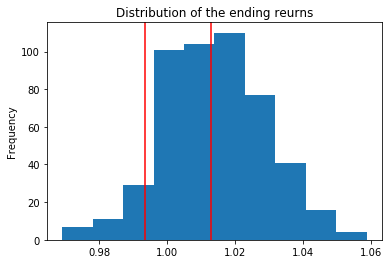

In [25]:
distribution = ending_cum.value_counts(bins=10)/len(ending_cum)
title2 = f"Distribution of the ending reurns"
ending_cum.plot.hist(title=title2)
plt.axvline(ending_cum.iloc[0], color='r')
plt.axvline(ending_cum.iloc[1], color='r')

In [13]:
cum_30 = monte_carlo.iloc[-1].quantile(q=[.1, .5, .9])

In [20]:
initial_investment = 20000
inves_10th = initial_investment + (initial_investment * cum_30.iloc[0])
inves_50th = initial_investment + (initial_investment * cum_30.iloc[1])
inves_90th = initial_investment + (initial_investment * cum_30.iloc[2])
print(f"Given an initial investment of $20,000 the return at the 10th percentile is ${inves_10th}, while at the  50th it's ${inves_50th}, and  the 90th percentil," 
      f"which is the most desirable, finishes off at ${inves_90th}" 
)

Given an initial investment of $20,000 the return at the 10th percentile is $2822073.1649428215, while at the  50th it's $4126709.0653449055, and  the 90th percentil,which is the most desirable, finishes off at $5803984.139739518


In [15]:
projected_yearly_income= 6085
_4_withdraw = inves_10th*.04
if _4_withdraw >= projected_yearly_income:
    print("A 4% withdraw rate exceeds the value of the 10th percentile.")
else:
    print("A 4% withdraw rate does not exceed the the 10th percentile value.")

A 4% withdraw rate exceeds the value of the 10th percentile.


In [19]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
_50_inc = round(inves_10th*1.5*.04, 2)
print(f"Given a 50% increase in the initial incestment, and a withdraw rate of 4%, would leave you with a value of ${_50_inc}")

Given a 50% increase in the initial incestment, and a withdraw rate of 4%, would leave you with a value of $169324.39
